## Visualizing the data:
This series of exercise make use of a handwritten digits dataset that consists of 5000 training examples, where Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image. The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

In [1]:
#import the libraries
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

Since the dataset was given in .mat format instead of the usual .txt format, I had to make use of scipy loadmat function for the job. Since loadmat load .mat files as a dictionary with variable names as keys,
assigning X and y is as simple as accessing the dict with the variables’ keys.

In [2]:
# reading the data
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

In [3]:
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


The code block below construct 100(10*10) subplots and randomly visualize 100 out of the 5000 training with (np.random.randint(0,5001))
examples using plt.imshow. Take note we have to reshape the training example back to 20 X 20 pixel 
before we can visualize it and adding order="F" as a parameter into the reshape function ensure 
that the orientation of the image is upright.

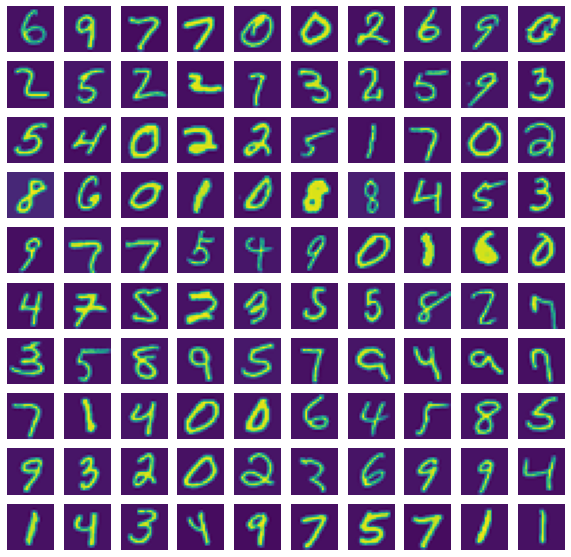

In [4]:
#visualizing the data

fig,axis=plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape((20,20),order="F"))
        axis[i,j].axis("off")

In [5]:
# visualizing the data
# _, axarr = plt.subplots(10,10,figsize=(10,10))
# for i in range(10):
#     for j in range(10):
#        axarr[i,j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order = 'F'))          
#        axarr[i,j].axis('off')

Our neural network has 3 layers — an input layer, a hidden layer and an output layer. Do recall that the inputs will be 20 x 20 grey scale images “unrolled” to form 400 input features which we will feed into the neural network. So our input layer has 400 neurons. Also the hidden layer has 25 neurons and the output layer 10 neurons corresponding to 10 digits (or classes) our model predicts. The +1 represents the bias term.
We have been provided with a set of already trained network parameters. These are stored in ex4weights.mat and will be loaded into theta1 and theta2 followed by unrolling into a vector nn_params. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes)
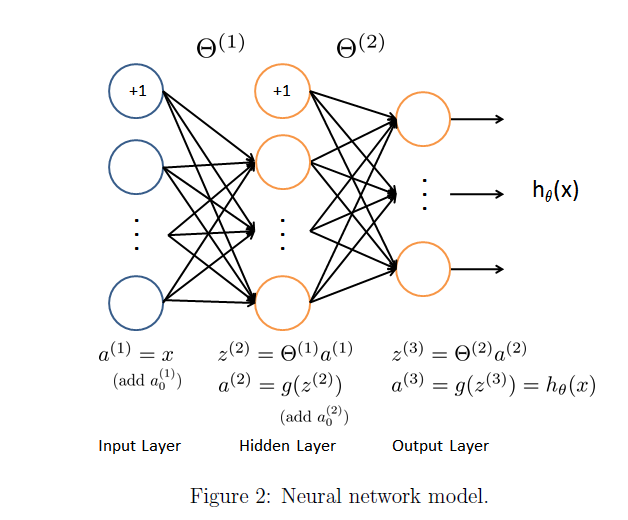

In [6]:
weights=loadmat('ex4weights.mat')
theta1=weights['Theta1'] # the theta1 has shape (25, 401) for hidden layer
theta2=weights['Theta2'] # theta 2 has shape(10,26) for output layer
nn_params = np.hstack((theta1.flatten(order='F'), theta2.flatten(order='F'))) # total 10285(=25*401+10*26)

#Nueral network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

In [7]:
nn_params.shape

(10285,)

## Feedforward and cost function
First we will implement the cost function followed by gradient for the neural network (for which we use backpropagation algorithm). Recall that the cost function for the neural network with regularization is

$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\Theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2]$

where h(x(i)) is computed as shown in the Figure 2 and K = 10 is the total number of possible labels. Note that h(x(i)) = a(3) is the activations of the output units. Also, whereas the original labels (in the variable y) were 1, 2, …, 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, such that

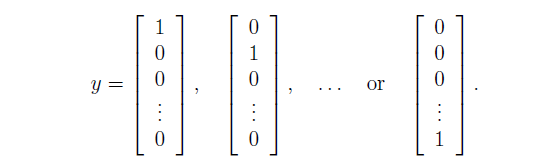

In [8]:
#sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
def nnCostFunc(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda):
    theta1= np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],(hidden_layer_size,input_layer_size+1),"F")
    theta2=np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],(num_labels,hidden_layer_size+1),"F")
    
    m=len(y)
    a1=np.hstack((np.ones((m,1)),X))
    a2=sigmoid(a1 @ theta1.T)
    a2=np.hstack((np.ones((m,1)),a2))
    h=sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)
    

In [10]:
nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

0.38376985909092354

## Backpropagation
In this part of the exercise, We will implement the backpropagation algorithm to compute the gradients for the neural network. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function using an advanced optimizer such as fmincg

## Sigmoid gradient
We will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

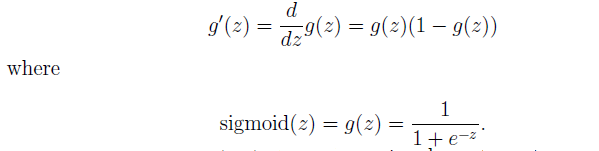

In [11]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    return np.multiply(sigmoid(z),(1-sigmoid(z)))

#return is g'(z2) = a2 . * (1 - a2)

## Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. Here we randomly initialize parameters named initial_theta1 and initial_theta2 corresponding to hidden layer and output layer and unroll into a single vector as we did earlier.

Select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

In [12]:
def randIntialzeWeights(L_in,L_out):
        
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    epsilon=(6**1/2) / (L_in + L_out)**1/2
    return np.random.rand(L_out,L_in+1)*2*epsilon -epsilon

In [13]:
initial_theta_1=randIntialzeweights(input_layer_size,hidden_layer_size)
initial_theta_2=randIntialzeweights(hidden_layer_size,num_labels)


# unrolling parameters into a single column vector
nn_initial_params=np.hstack((initial_theta_1.flatten(order="F"),initial_theta_2.flatten(order="F")))

## Backpropagation

In summary we do the following by looping through every training example:
1. Compute the forward propagate to get the output activation a3.
2. Calculate the error term d3 that’s obtained by subtracting actual output from our calculated output a3.
3. For hidden layer, error term d2 can be calculated as below:

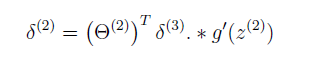
    
4. Accumulate the gradients in delta1 and delta2 .
5. Obtain the gradients for the neural network by diving the accumulated gradients (of step 4) by m.
6. Add the regularization terms to the gradients.

In [33]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    #we will pass here nn_intial parameters which is randomly initailzed
    initial_theta1=np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],(hidden_layer_size,input_layer_size+1),"F")
    initial_theta2=np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],(num_labels,hidden_layer_size+1),"F")
    y_d=pd.get_dummies(y.flatten()) #Y_d is a df having 10 columns as one hot encoding
    delta1=np.zeros(initial_theta_1.shape)
    delta2=np.zeros(initial_theta2.shape)
    m=len(y)
    
#     #for i = 1:m 
# {
# Forward propagation on (xi, yi) --> get activation (a) terms
# Back propagation on (xi, yi) --> get delta (δ) terms
# Compute Δ := Δl + δl+1(al)T
# }
    
    for i in range(X.shape[0]):
        ones=np.ones(1)
        a1=np.hstack((ones,X[i]))
        z2=a1 @ initial_theta1.T
        a2=np.hstack((ones,sigmoid(z2)))
        z3= a2 @ initial_theta2.T
        a3=sigmoid(z3)
        
        d3=a3-y_d.iloc[i,:][np.newaxis,:] # this will take the ith column,Newaxis will make it as an array row value because a3 is also array or matrix 1*10
        z2=np.hstack((ones,z2))
        d2=np.multiply((initial_theta2.T @ d3.T),sigmoidGradient(z2).T[:,np.newaxis])
        delta1=delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2=delta2 + d3.T @a2[np.newaxis,:]
        
    delta1=delta1/m
    delta2=delta2/m
        
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))
        

By the way, the for-loop in the above code can be eliminated if you can use a highly vectorized implementation. But for those who are new to backprop it is okay to use for-loop to gain a much better understanding. Running the above function with initial parameters gives nn_backprop_Params which we will be using while performing gradient checking.

In [35]:
nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

## Gradient checking
Why do we need Gradient checking ? To make sure that our backprop algorithm has no bugs in it and works as intended. We can approximate the derivative of our cost function with:
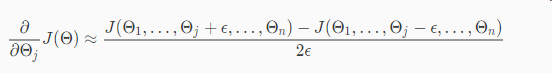
The gradients computed using backprop and numerical approximation should agree to at least 4 significant digits to make sure that our backprop implementation is bug free.

In [57]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda):
    epsilon=0.0001
    flattenedTheta=nn_initial_params
    flattenedDs=nn_backprop_Params
    n_elms=len(flattenedTheta)
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
            x=int(np.random.rand()*n_elms)
            epsilonVec=np.zeros((n_elms,1))
            epsilonVec[x]=epsilon
            
            cost_high = nnCostFunc(flattenedTheta + epsilonVec.flatten(),input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)
            cost_low = nnCostFunc(flattenedTheta - epsilonVec.flatten(),input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)
            mygrad = (cost_high - cost_low) / float(2*epsilon)
            print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))

In [58]:
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 9423. Numerical Gradient = -0.000022582. BackProp Gradient = -0.000022582.
Element: 7402. Numerical Gradient = -0.001190836. BackProp Gradient = -0.001190836.
Element: 6523. Numerical Gradient = -0.000037457. BackProp Gradient = -0.000037457.
Element: 10104. Numerical Gradient = 0.144063662. BackProp Gradient = 0.144063662.
Element: 3547. Numerical Gradient = -0.000019530. BackProp Gradient = -0.000019530.
Element: 4898. Numerical Gradient = -0.007155791. BackProp Gradient = -0.007155790.
Element: 9925. Numerical Gradient = 0.000012448. BackProp Gradient = 0.000012448.
Element: 4193. Numerical Gradient = 0.003699020. BackProp Gradient = 0.003699020.
Element: 3019. Numerical Gradient = -0.000033387. BackProp Gradient = -0.000033387.
Element: 933. Numerical Gradient = -0.000005510. BackProp Gradient = -0.000005510.


## Learning parameters using fmincg
After you have successfully implemented the neural network cost function and gradient computation, the next step is to use fmincg to learn a good set of parameters for the neural network. theta_opt contains unrolled parameters that we just learnt which we roll to get theta1_opt and theta2_opt.

In [59]:
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_initial_params, fprime = nnGrad, \
                        args = (input_layer_size, hidden_layer_size, num_labels, X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

         Current function value: 0.434000
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


## Prediction using learned parameters
It’s time to see how well our newly learned parameters are performing by calculating the accuracy of the model. Do recall that when we used linear classifier like Logistic Regression we got an accuracy of 95.08%. Neural network should give us a better accuracy.

In [61]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1

In [62]:
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred == y.flatten()) * 100

96.6

This should give a value of 96.5% (this may vary by about 1% due to the random initialization). It is to be noted that by tweaking the hyperparameters we can still obtain a better accuracy.

## End Notes
We just saw how neural networks can be used to perform complex tasks like digit recognition, and in the process also got to know about backpropagation algorithm.